In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from minisom import MiniSom, asymptotic_decay
import matplotlib.pyplot as plt

In [2]:
ds_2t = xr.open_dataset("/glade/scratch/kiarar/ERA5_2T_1979_2021.nc")
#ds_u = xr.open_dataset("/glade/scratch/kiarar/ERA5_U_winds_200_1979_2018.nc")
#ds_v = xr.open_dataset("/glade/scratch/kiarar/ERA5_V_winds_200_1979_2018.nc")
#ds_Z = xr.open_dataset("/glade/scratch/kiarar/ERA5_geopotential_winds_500_1979_2018.nc")

In [3]:
#slice data in time to make it match the other data... 
ds_2t = ds_2t.isel(time=slice(0,480))

In [4]:
ds_2t

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 281, time: 480)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
  * latitude   (latitude) float64 60.0 59.75 59.5 59.25 ... 15.5 15.25 15.0
  * longitude  (longitude) float64 230.0 230.2 230.5 230.8 ... 299.5 299.8 300.0
Data variables:
    VAR_2T     (time, latitude, longitude) float32 ...
    utc_date   (time, longitude, latitude) float64 ...

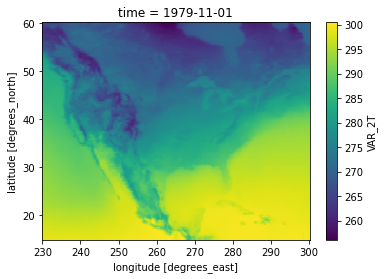

In [5]:
ds_2t["VAR_2T"].isel(time=10).plot()

In [6]:
#Stacking longitude and latitude into one column
subset_2t = ds_2t["VAR_2T"].stack(new=("latitude", "longitude")).values

# Self-Organizing Map Training

In [7]:
som_grid_rows = 3
som_grid_columns = 3
input_length = subset_2t.shape[1] 

In [8]:
input_length

50861

In [9]:
sigma = 0.3
learning_rate = 0.001
decay_function = asymptotic_decay

In [10]:
neighborhood_function = "gaussian"
topology = "rectangular"
activation_distance = 'euclidean'
random_seed = 1

In [11]:
som = MiniSom(
            som_grid_rows,
            som_grid_columns,
            input_length,
            sigma,
            learning_rate,
            decay_function,
            neighborhood_function,
            topology,
            activation_distance,
            random_seed)

In [12]:
def normalize_data(data):
    """
    Function for normalizing data prior to training using z-score
    """
    return (data - np.nanmean(data)) / np.nanstd(data)

In [13]:
data = normalize_data(subset_2t)
num_iteration = 100000
random_order = True
verbose = True

In [14]:
som.random_weights_init(data)

In [15]:
som.train(
        data,
        num_iteration,
        random_order,
        verbose)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 31.998955294829912


In [16]:
som.topographic_error(data)

0.73125

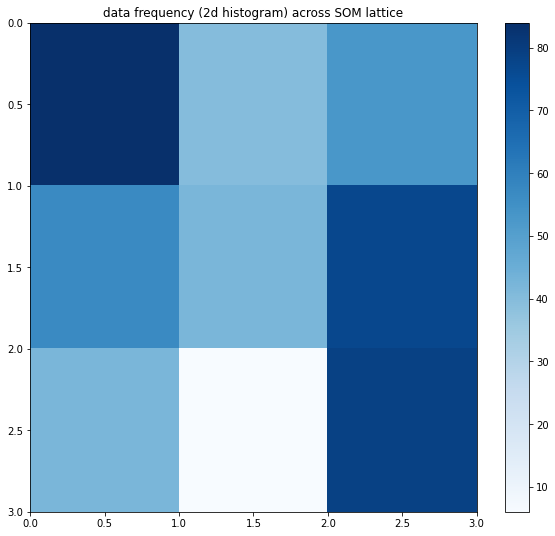

In [17]:
plt.figure(figsize=(10, 9))
frequencies = (som.activation_response(data))
plt.pcolormesh(frequencies, cmap='Blues') 
plt.colorbar()
plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
plt.ylim(som_grid_rows, 0)  # flip the y axis to be the same as composite map axes later
#plt.savefig('winds_freq.png', bbox_inches='tight', dpi=200)
plt.show()

# Visualizing Large-Scale Regimes

In [18]:
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from itertools import product

In [19]:
keys = [i for i in product(range(som_grid_rows),range(som_grid_columns))]

In [20]:
winmap = {key: [] for key in keys}
# grab the indices for the data within the SOM lattice
for i, x in enumerate(data):
    winmap[som.winner(x)].append(i)

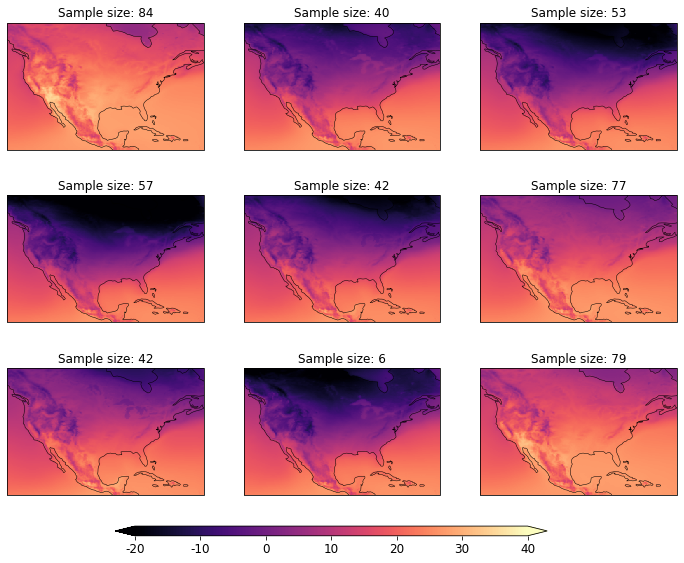

In [21]:
# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(12,9))

# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 

for map_num in range(len(keys)):
    
    # the data
    lt = ds_2t['VAR_2T'][np.array(winmap[keys[map_num]])].coords['latitude'].values
    ln = ds_2t['VAR_2T'][np.array(winmap[keys[map_num]])].coords['longitude'].values
    temp_data = ds_2t["VAR_2T"][np.array(winmap[keys[map_num]])].mean(dim="time", skipna=True).values
    
    # plot
    cs = axs[keys[map_num][0],keys[map_num][1]].pcolormesh(ln, lt, temp_data - 273.15, cmap="magma", vmin=-20, vmax=40, transform=ccrs.PlateCarree())
    
    # title
    axs[keys[map_num][0],keys[map_num][1]].set_title(f"Sample size: {int(frequencies.flatten()[map_num])}", fontsize=12)
    
    # kwargs
    axs[keys[map_num][0],keys[map_num][1]].coastlines(resolution='110m', color='k', linewidth=0.5, zorder=10)
    axs[keys[map_num][0],keys[map_num][1]].margins(x=0,y=0)
    
# colorbar stuff
cax = plt.axes([0.25, 0.075, 0.5, 0.015])
cbar = plt.colorbar(cs, orientation="horizontal", cax=cax, extend='both')
cbar.set_ticks([-20,-10,0,10,20,30,40])
cbar.ax.set_xticklabels([-20,-10,0,10,20,30,40],fontsize=12)
    
#plt.savefig('winds_freq.png', bbox_inches='tight', dpi=200)
plt.show()